## Diagnostics

In [1]:
from glob import glob
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
import xgcm
from xorca.lib import load_xorca_dataset
import pickle
import eddytools as et
from cmocean import cm
from dask.diagnostics import ProgressBar
import pandas as pd
import cartopy.crs as ccrs
# from datetime import timedelta
# import matplotlib.colors as colors
import cartopy.feature as cfeature

import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [2]:
import dask, dask.distributed
import dask_jobqueue
cluster = dask_jobqueue.SLURMCluster(cores=8,memory='50GB',processes=1,queue='large96:shared', walltime='5:00:00',interface='ib0',local_directory='$TMPDIR')
client = dask.distributed.Client(cluster)
cluster.scale(jobs=8)

In [3]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://10.246.8.1:8787/status,
Dashboard: http://10.246.8.1:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.246.8.1:38361,Workers: 0
Dashboard: http://10.246.8.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


### loading data

In [4]:
# mask
meshpath = ['/scratch/usr/shkifmjr/NUSERDATA/ORION/10-data/meshmask/1_mesh_mask.nc']
mask_10 = xr.open_dataset(meshpath[0], chunks={"y":100, "x":100}).tmask.isel(z=0).squeeze()
mask_10_base = xr.open_dataset('/scratch/usr/shkifmjr/NUSERDATA/ORION/10-data/meshmask/mesh_mask.nc', chunks={"y":100, "x":100}).tmask.isel(z=0).squeeze()
e0t = xr.open_dataset(meshpath[0], chunks={"y":100, "x":100}).isel(t=0)[['e1t','e2t']].squeeze()

# observational data
obs_path = '/scratch/usr/shkifmmp/master/data/observations/'

# DATA DETECTION
datapath= '/scratch/usr/shkifmmp/manusc/data/'

# Path to Lavinia's folder
path_05 = '/scratch/usr/shklvn09/SCRATCH/ORION10.L46.LIM2vp.CFCSF6.MOPS.JRA.XIOS2.5.LP01-EXP05/OUT/'#Drake/'
path_06 = '/scratch/usr/shklvn09/SCRATCH/ORION10.L46.LIM2vp.CFCSF6.MOPS.JRA.XIOS2.5.LP01-EXP06/OUT/'

# DATA DETECTION
datapath= '/scratch/usr/shkifmmp/manusc/data/'

# acc mask - FOR DETECTION ONLY
# mask_acc = xr.open_dataset('/scratch/usr/shkifmmp/master/data/ORION10/interpolated/int_mask_regions.nc').mask_regions

# acc mask -normal plotting and computation
mask_acc = xr.open_dataset('/scratch/usr/shkifmmp/master/data/ORION10/mask/mask_nest_int_2d.nc', chunks={"y":100, "x":100}).mask_nest

In [64]:
mask_plot = mask_acc.where(mask_acc ==0, other=1)

mask_plot = mask_plot.where(mask_plot.nav_lat >= -65, other=0)
mask_plot = mask_plot.where(mask_plot.nav_lon > 75.5, other=0)
mask_plot = mask_plot.where(mask_plot.nav_lon < 431.58, other=0)

In [5]:
# for auxiliary calculation only
latlon_aux = xr.open_mfdataset(paths=sorted(glob(datapath + 'EXP06/EKE/1*2002*EKE_k10.nc')), chunks = {"y": 100, "x":100})[['nav_lat', 'nav_lon']]

In [6]:
# for auxiliary calculation only
latlon_aux_base = xr.open_mfdataset(paths=sorted(glob(datapath + 'EXP06/EKE/O*2002*EKE_k10.nc')), chunks = {"y": 100, "x":100})[['nav_lat', 'nav_lon']]

In [35]:
# (((155*1e3)**2)*np.pi)/(8647.995188**2) # r**2 * pi / (e1f*e2f) # gives the number of pixels

1009.2119642438435

In [37]:
# (np.sqrt(((8647.995188**2) * 1038) /np.pi) * 2) /1e3 #reversed calculation, giving pixels and e1f,e2f, gives back the diameter of the eddy that could be found

314.39032695704515

### EKE 

In [8]:
#nest
eke_6 = xr.open_mfdataset(paths=sorted(glob(datapath + 'EXP06/EKE/1*EKE_k10.nc')), chunks = {"y": 100, "x":100}).vozocrtx.squeeze().where(mask_10)

In [9]:
eke_6 = eke_6.isel(x=slice(1,-1), y=slice(1,-1))

In [10]:
eke_5 = xr.open_mfdataset(paths = sorted(glob(datapath + 'EXP05/EKE_nest/1*EKE_k10.nc')), chunks={"y":100, "x":100}).vozocrtx.squeeze().where(mask_10)

In [11]:
eke_5 = eke_5.isel(x=slice(1,-1), y=slice(1,-1))

In [18]:
eke_6w = eke_6.where((eke_6.nav_lat >= -67) & (eke_6.nav_lat <= -30),drop=True)

In [19]:
eke_5w = eke_5.where((eke_5.nav_lat >= -67) & (eke_5.nav_lat <= -30),drop=True)

#### weighted mean

In [6]:
def weighted_mean(variable, weight, mask): #check this None if it works
    variable = variable.where(mask)
    weight = weight.where(mask)
    return (variable * weight).sum(('x','y')) / weight.sum(('x','y'))

In [7]:
area = (e0t.e1t * e0t.e2t).where((latlon_aux.nav_lat >= -67) & (latlon_aux.nav_lat <= -30),drop=True).compute()

In [23]:
# whole region
eke6_wmean = weighted_mean_mod(eke_6w, area.isel(x=slice(1,-1))).compute()

eke5_wmean = weighted_mean_mod(eke_5w, area.isel(x=slice(1,-1))).compute()

In [12]:
area_acc = (e0t.e1t * e0t.e2t).isel(x=slice(1,-1), y=slice(1,-1))

In [14]:
# within acc mask
eke6_acc = weighted_mean(eke_6, area_acc, mask_acc).compute()

In [15]:
eke5_acc = weighted_mean(eke_5, area_acc, mask_acc).compute()

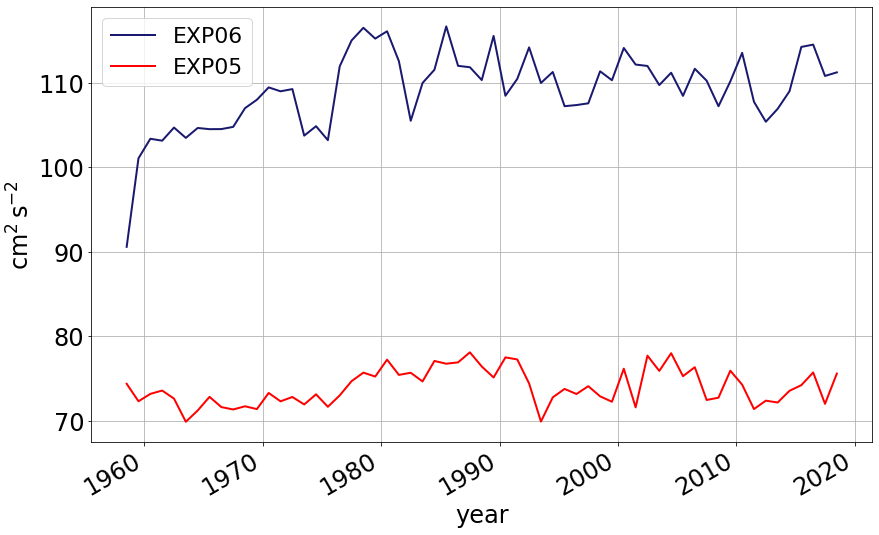

In [25]:
fig, axs = plt.subplots(figsize=(14,8))

(eke6_wmean*1e4).plot(ax=axs, label='EXP06', color='midnightblue', linewidth=2)
(eke5_wmean*1e4).plot(ax=axs, label= 'EXP05', color='red', linewidth=2)

# (eke6_acc*1e4).plot(ax=axs, label='EXP06', color='midnightblue', linewidth=2)
# (eke5_acc*1e4).plot(ax=axs, label= 'EXP05', color='red', linewidth=2)

# axs.axvline(x=dt.datetime(1978,7,1), color='k', linestyle='--', linewidth=2)
# axs.axvline(x=dt.datetime(1998,7,1), color='k', linestyle='--', linewidth=2)
axs.set_title(None)
axs.tick_params(axis= 'x', labelsize= 24)
axs.tick_params(axis= 'y', labelsize= 24)
axs.set_xlabel('year', fontsize=24)
# axs.set_ylabel('EKE at 100m (cm$^{2}\,$s$^{-2}$)', fontsize=24)
axs.set_ylabel('cm$^{2}\,$s$^{-2}$', fontsize=24)
axs.grid()

plt.legend(fontsize=22)

save_path = '/home/shkifmmp/_WORK/notebooks/shared-notebooks/fig_paper/diagnostics/'
plt.savefig(save_path + 'eke_whole_timeseries.png', format='png', facecolor="w",  bbox_inches='tight')

### ACC strength

In [81]:
drake_05 = xr.open_mfdataset(paths = sorted(glob(path_05_old + 'Drake/1_*1958*2017*transports.nc') + 
                            glob(datapath + 'EXP05/1_*2018*transports.nc'))).vtrp.squeeze()

In [83]:
drake_06 = xr.open_mfdataset(paths=sorted(glob(datapath + 'EXP06/drake_transp/1_*transports.nc'))).vtrp.squeeze()

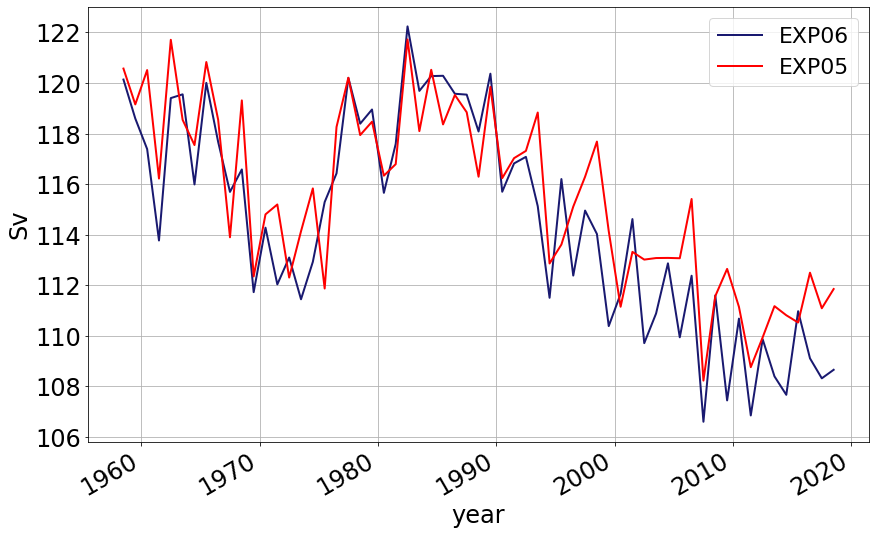

In [88]:
fig, axs = plt.subplots(figsize=(14,8))

drake_06.plot(ax=axs, label='EXP06', color='midnightblue', linewidth=2)
drake_05.plot(ax=axs, label= 'EXP05', color='red', linewidth=2)

# axs.axvline(x=dt.datetime(1978,7,1), color='k', linestyle='--', linewidth=2)
# axs.axvline(x=dt.datetime(1998,7,1), color='k', linestyle='--', linewidth=2)
axs.set_title(None)
axs.tick_params(axis= 'x', labelsize= 24)
axs.tick_params(axis= 'y', labelsize= 24)
axs.set_xlabel('year', fontsize=24)
# axs.set_ylabel('EKE at 100m (cm$^{2}\,$s$^{-2}$)', fontsize=24)
axs.set_ylabel('Sv', fontsize=24)
axs.grid()

plt.legend(fontsize=22)

save_path = '/home/shkifmmp/_WORK/notebooks/shared-notebooks/fig_paper/diagnostics/'
plt.savefig(save_path + 'drake_timeseries.png', format='png', facecolor="w",  bbox_inches='tight')

### Wind stress

master way

In [28]:
# for year in np.arange(1958,2019):
#     wind_u_5 = xr.open_mfdataset(paths=sorted(glob(path_05 + 'O*5d*' + '0101_' + str(year) + '1231_grid_U*')),
#                          chunks={'y':100, 'x':100}).sozotaux.squeeze()

#     wind_u_5 = wind_u_5#.isel(x=slice(1,-1), y=slice(1,-1))

#     wind_v_5 = xr.open_mfdataset(paths=sorted(glob(path_05 + 'O*5d*' + '0101_' + str(year) + '1231_grid_V*')),
#                              chunks={'y':100, 'x':100}).sometauy.squeeze()

#     wind_v_5 = wind_v_5#.isel(x=slice(1,-1), y=slice(1,-1))
    
#     ws_05_O = np.abs(np.sqrt(wind_u_5**2 + wind_v_5**2)).compute()
    
#     ws_05_O.to_dataset(name="tau").to_netcdf(path='/scratch/usr/shkifmmp/manusc/data/EXP05/wind/' +
#                       'ORION10.L46.LIM2vp.CFCSF6.MOPS.JRA.XIOS2.5.LP01-EXP05_5d_' + str(year) + '0101_' + str(year) + '1231_grid_TAU.nc',
#                      )

### time series

In [7]:
#nest
tau_6 = xr.open_mfdataset(paths = sorted(glob(datapath + 'EXP06/wind/1_*TAU.nc')),
                         chunks=({'x': 100, 'y': 100})).tau.where(mask_10.isel(x=slice(1,-1), y=slice(1,-1)))

In [8]:
tau_5 = xr.open_mfdataset(paths = sorted(glob(datapath + 'EXP05/wind/1_*TAU.nc')),
                         chunks=({'x': 100, 'y': 100})).tau.where(mask_10.isel(x=slice(1,-1), y=slice(1,-1)))

In [9]:
#base
tau_6_b = xr.open_mfdataset(paths = sorted(glob(datapath + 'EXP06/wind/O*TAU.nc')),
                         chunks=({'x': 100, 'y': 100})).tau.where(mask_10_base)

In [10]:
tau_5_b = xr.open_mfdataset(paths = sorted(glob(datapath + 'EXP05/wind/O*TAU.nc')),
                         chunks=({'x': 100, 'y': 100})).tau.where(mask_10_base)

In [11]:
tau_6 = tau_6.assign_coords(nav_lat = latlon_aux.nav_lat.isel(x=slice(1,-1), y=slice(1,-1)), nav_lon = latlon_aux.nav_lon.isel(x=slice(1,-1), y=slice(1,-1)))

In [12]:
tau_5 = tau_5.assign_coords(nav_lat = latlon_aux.nav_lat.isel(x=slice(1,-1), y=slice(1,-1)), nav_lon = latlon_aux.nav_lon.isel(x=slice(1,-1), y=slice(1,-1)))

In [13]:
tau_6_b = tau_6_b.assign_coords(nav_lat = latlon_aux_base.nav_lat, nav_lon = latlon_aux_base.nav_lon)
tau_5_b = tau_5_b.assign_coords(nav_lat = latlon_aux_base.nav_lat, nav_lon = latlon_aux_base.nav_lon)

### acc

In [10]:
tau_6_acc = weighted_mean(tau_6, area_acc, mask_acc).compute()

In [11]:
tau_5_acc = weighted_mean(tau_5, area_acc, mask_acc).compute()

In [13]:
tau_6_acc_mean = tau_6_acc.groupby('time_counter.year').mean().compute()

In [14]:
tau_5_acc_mean = tau_5_acc.groupby('time_counter.year').mean().compute()

In [17]:
tau_6_acc_mean = tau_6_acc_mean.rename({'year': 'time_counter'})

In [18]:
tau_5_acc_mean = tau_5_acc_mean.rename({'year': 'time_counter'})

### whole region

In [31]:
tau_6_whole = tau_6.where((tau_6.nav_lat >= -67) & (tau_6.nav_lat <= -30), drop=True)

/home/shkifmmp/miniconda3/envs/py3_eddy/lib/python3.8/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [32]:
tau_5_whole = tau_5.where((tau_5.nav_lat >= -67) & (tau_5.nav_lat <= -30), drop=True)

/home/shkifmmp/miniconda3/envs/py3_eddy/lib/python3.8/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [21]:
def weighted_mean_mod(variable, weight):#, mask): #check this None if it works
#     variable = variable.where(mask)
#     weight = weight.where(mask)
    return (variable * weight).sum(('x','y')) / weight.sum(('x','y'))

In [48]:
tau_6_whole_mean = weighted_mean_mod(tau_6_whole, area.isel(x=slice(1,-1))).compute()

In [49]:
tau_5_whole_mean = weighted_mean_mod(tau_5_whole, area.isel(x=slice(1,-1))).compute()

In [50]:
tau_6_whole_mean = tau_6_whole_mean.groupby('time_counter.year').mean().rename({'year': 'time_counter'})

In [51]:
tau_5_whole_mean = tau_5_whole_mean.groupby('time_counter.year').mean().rename({'year': 'time_counter'})

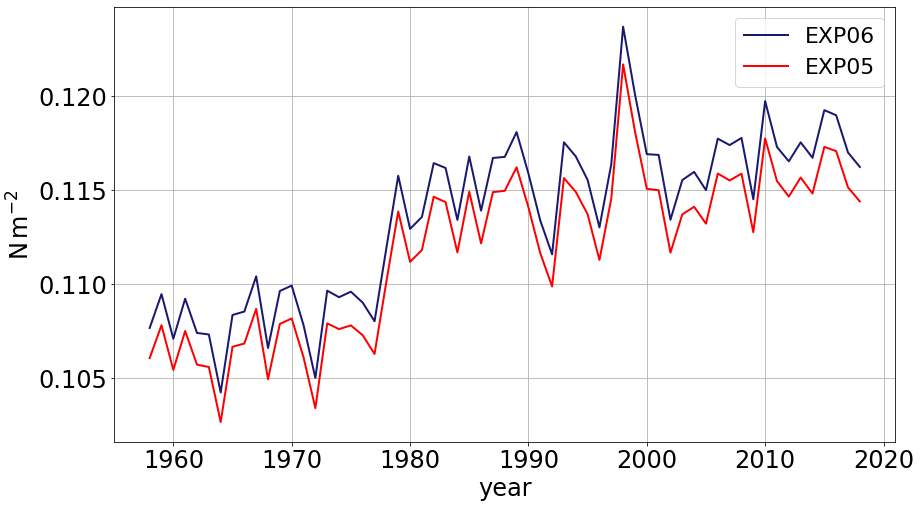

In [58]:
fig, axs = plt.subplots(figsize=(14,8))

# tau_6_acc_mean.plot(ax=axs, label='EXP06', color='midnightblue', linewidth=2)
# tau_5_acc_mean.plot(ax=axs, label= 'EXP05', color='red', linewidth=2)

tau_6_whole_mean.plot(ax=axs, label='EXP06', color='midnightblue', linewidth=2)
tau_5_whole_mean.plot(ax=axs, label= 'EXP05', color='red', linewidth=2)

# axs.axvline(x=dt.datetime(1978,7,1), color='k', linestyle='--', linewidth=2)
# axs.axvline(x=dt.datetime(1998,7,1), color='k', linestyle='--', linewidth=2)
axs.set_title(None)
axs.tick_params(axis= 'x', labelsize= 24)
axs.tick_params(axis= 'y', labelsize= 24)
axs.set_xlabel(None)
axs.set_ylabel('N$\,$m$^{-2}$', fontsize=24)
# axs.set_ylabel('N$\,$m$^{-2}$', fontsize=24)

axs.set_xlabel('year', fontsize=24)

axs.grid()

plt.legend(fontsize=22)
# plt.title(', loc='left', fontsize=22)

save_path = '/home/shkifmmp/_WORK/notebooks/shared-notebooks/fig_paper/diagnostics/'
# plt.savefig(save_path + 'wind_stress_whole_timeseries.png', format='png', facecolor="w",  bbox_inches='tight')

### maps
correcting discontinuity

In [28]:
tau_6.coords["x"], tau_6.coords["y"] = range(len(tau_6.x)), range(len(tau_6.y))
tau_5.coords["x"], tau_5.coords["y"] = range(len(tau_5.x)), range(len(tau_5.y))

tau_6_b.coords["x"], tau_6_b.coords["y"] = range(len(tau_6_b.x)), range(len(tau_6_b.y))
tau_5_b.coords["x"], tau_5_b.coords["y"] = range(len(tau_5_b.x)), range(len(tau_5_b.y))

In [29]:
after_discont = ~(tau_6.coords["nav_lon"].diff("x", label="upper") > 0).cumprod("x").astype(bool)
after_discont_base = ~(tau_6_b.coords["nav_lon"].diff("x", label="upper") > 0).cumprod("x").astype(bool)

In [30]:
tau_6.coords["nav_lon"] = (
    tau_6.coords["nav_lon"]
    + 360 * after_discont)

tau_6_b.coords["nav_lon"] = (
    tau_6_b.coords["nav_lon"]
    + 360 * after_discont_base)

tau_5.coords["nav_lon"] = (
    tau_5.coords["nav_lon"]
    + 360 * after_discont)

tau_5_b.coords["nav_lon"] = (
    tau_5_b.coords["nav_lon"]
    + 360 * after_discont_base)

In [43]:
tau_6_b = tau_6_b.isel(x=slice(1,None))
tau_5_b = tau_5_b.isel(x=slice(1,None))

tau_6 = tau_6.isel(x=slice(1,None))
tau_5 = tau_5.isel(x=slice(1,None))

In [59]:
tau_6_mean = tau_6.sel(time_counter=slice('1993','2018')).mean('time_counter').compute()

In [60]:
tau_6_b_mean = tau_6_b.sel(time_counter=slice('1993','2018')).mean('time_counter').compute()

In [61]:
tau_5_mean = tau_5.sel(time_counter=slice('1993','2018')).mean('time_counter').compute()

In [74]:
tau_5_b_mean = tau_5_b.sel(time_counter=slice('1993','2018')).mean('time_counter').compute()

In [76]:
tau_5_mean.max(), tau_5_b_mean.max(), tau_6_mean.max(), tau_6_b_mean.max()

(<xarray.DataArray 'tau' ()>
 array(0.3758935),
 <xarray.DataArray 'tau' ()>
 array(0.43446079),
 <xarray.DataArray 'tau' ()>
 array(0.38340729),
 <xarray.DataArray 'tau' ()>
 array(0.44681036))

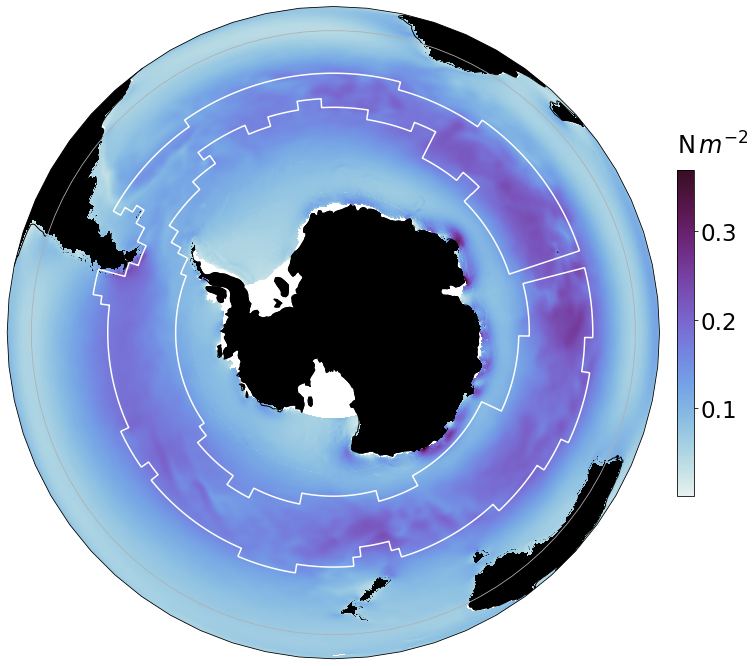

In [81]:
# plotting

fig, axs = plt.subplots(figsize=(16,12), subplot_kw = {'projection': ccrs.NearsidePerspective(central_latitude = -90)})

map1 = tau_6_mean.plot(x='nav_lon', y='nav_lat', transform = ccrs.PlateCarree(), ax= axs, zorder = 3,
                               add_colorbar= False, #norm=colors.LogNorm(vmin=1e-0, vmax=1000), 
                       vmax=0.37, vmin=0.001,
                       cmap= cm.dense)

tau_6_b_mean.plot(x='nav_lon', y='nav_lat', transform = ccrs.PlateCarree(), ax= axs, zorder = 1,
                               add_colorbar= False,# norm=colors.LogNorm(vmin=1e-0, vmax=1000),
                  vmax=0.37, vmin=0.001,
                               cmap = cm.dense)

axs.contour(mask_acc.nav_lon, mask_acc.nav_lat, mask_plot, transform= ccrs.PlateCarree(),
            colors='white', levels=[1], linewidth=15, zorder=5)

axs.gridlines(ylocs=[-30], zorder=7, colors='white').xlines = False

c = plt.colorbar(map1, pad=0.02, shrink=0.5, ax=axs)
c.ax.set_title('N$\,m^{-2}$', loc='left', fontsize=24, y=1.03)

axs.set_global()
axs.coastlines()
axs.add_feature(cfeature.LAND, color='black')
c.ax.tick_params(labelsize=23)
# axes.Axes.tick_params(axs, axis='both' ,labelsize=24)

axs.set_title(None)

savepath = '/home/shkifmmp/_WORK/notebooks/shared-notebooks/fig_paper/diagnostics/'
plt.savefig(savepath + 'wstress_9318_map_EXP06.png', format='png', facecolor="w", bbox_inches='tight')

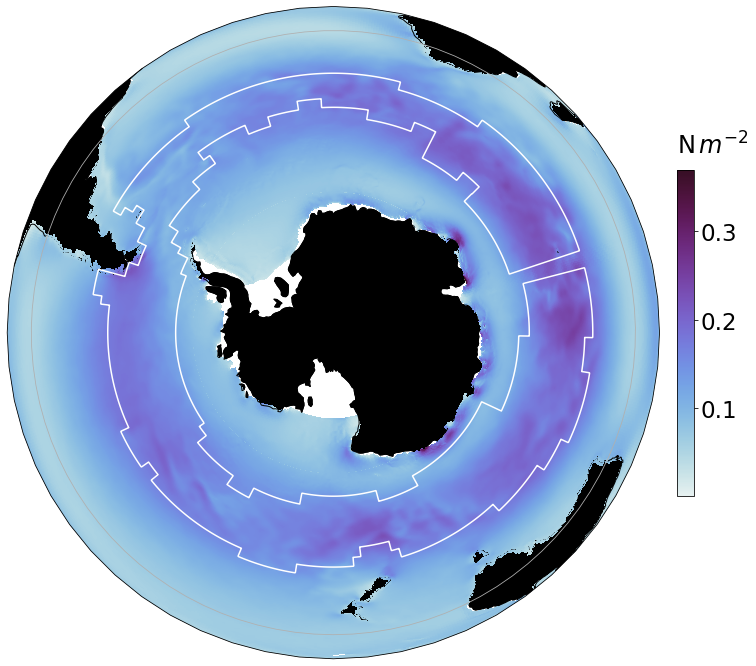

In [82]:
# plotting

fig, axs = plt.subplots(figsize=(16,12), subplot_kw = {'projection': ccrs.NearsidePerspective(central_latitude = -90)})

map1 = tau_5_mean.plot(x='nav_lon', y='nav_lat', transform = ccrs.PlateCarree(), ax= axs, zorder = 3,
                               add_colorbar= False, #norm=colors.LogNorm(vmin=1e-0, vmax=1000), 
                       vmax=0.37, vmin=0.001,
                       cmap= cm.dense)

tau_5_b_mean.plot(x='nav_lon', y='nav_lat', transform = ccrs.PlateCarree(), ax= axs, zorder = 1,
                               add_colorbar= False,# norm=colors.LogNorm(vmin=1e-0, vmax=1000),
                  vmax=0.37, vmin=0.001,
                               cmap = cm.dense)

axs.contour(mask_acc.nav_lon, mask_acc.nav_lat, mask_plot, transform= ccrs.PlateCarree(),
            colors='white', levels=[1], linewidth=15, zorder=5)

axs.gridlines(ylocs=[-30], zorder=7, colors='white').xlines = False

c = plt.colorbar(map1, pad=0.02, shrink=0.5, ax=axs)
c.ax.set_title('N$\,m^{-2}$', loc='left', fontsize=24, y=1.03)

axs.set_global()
axs.coastlines()
axs.add_feature(cfeature.LAND, color='black')
c.ax.tick_params(labelsize=23)
# axes.Axes.tick_params(axs, axis='both' ,labelsize=24)

axs.set_title(None)

savepath = '/home/shkifmmp/_WORK/notebooks/shared-notebooks/fig_paper/diagnostics/'
plt.savefig(savepath + 'wstress_9318_map_EXP05.png', format='png', facecolor="w", bbox_inches='tight')

/home/shkifmmp/miniconda3/envs/py3_eddy/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/home/shkifmmp/miniconda3/envs/py3_eddy/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/home/shkifmmp/miniconda3/envs/py3_eddy/lib/pyth

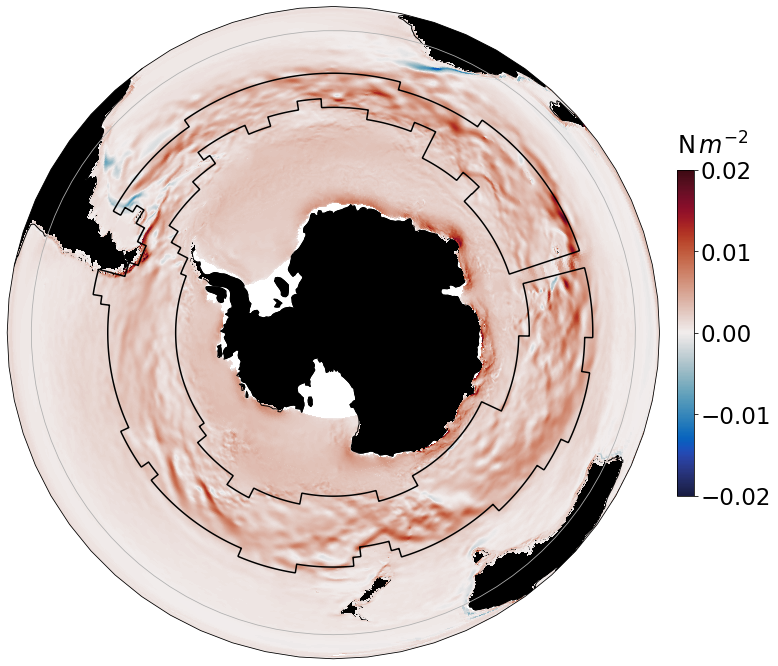

In [92]:
# plotting

fig, axs = plt.subplots(figsize=(16,12), subplot_kw = {'projection': ccrs.NearsidePerspective(central_latitude = -90)})

map1 = (tau_6_mean - tau_5_mean).plot(x='nav_lon', y='nav_lat', transform = ccrs.PlateCarree(), ax= axs, zorder = 3,
                               add_colorbar= False, #norm=colors.LogNorm(vmin=1e-0, vmax=1000), 
                       vmax=0.02, vmin=-0.02,
                       cmap= cm.balance)

(tau_6_b_mean - tau_5_b_mean).plot(x='nav_lon', y='nav_lat', transform = ccrs.PlateCarree(), ax= axs, zorder = 1,
                               add_colorbar= False,# norm=colors.LogNorm(vmin=1e-0, vmax=1000),
                  vmax=0.02, vmin=-0.02,
                               cmap = cm.balance)

axs.contour(mask_acc.nav_lon, mask_acc.nav_lat, mask_plot, transform= ccrs.PlateCarree(),
            colors='black', levels=[1], linewidth=15, zorder=5)

axs.gridlines(ylocs=[-30], zorder=7, colors='white').xlines = False

c = plt.colorbar(map1, pad=0.02, shrink=0.5, ax=axs)
c.ax.set_title('N$\,m^{-2}$', loc='left', fontsize=24, y=1.03)

axs.set_global()
axs.coastlines()
axs.add_feature(cfeature.LAND, color='black')
c.ax.tick_params(labelsize=23)
# axes.Axes.tick_params(axs, axis='both' ,labelsize=24)

axs.set_title(None)

savepath = '/home/shkifmmp/_WORK/notebooks/shared-notebooks/fig_paper/diagnostics/'
# plt.savefig(savepath + 'wstress_9318_map_diff.png', format='png', facecolor="w", bbox_inches='tight')

In [89]:
(tau_6_mean - tau_5_mean).max(), 

(<xarray.DataArray 'tau' ()>
 array(0.02500981),)

#### get surface total velocity

In [32]:
for year in np.arange(1958,2019):
#     u_u = xr.open_mfdataset(paths=sorted(glob(path_06 + '1_*5d*' + '0101_' + str(year) + '1231_grid_U*'))#,
#                          #chunks={'y':100, 'x':100}
#                            ).vozocrtx.isel(depthu=0).squeeze()

    u_u = xr.open_mfdataset(paths=sorted(glob(datapath + 'EXP06/wind/' + 'O*5d*' + '0101_' + str(year) + '1231_grid_UU*'))#, squared velocity
                     #chunks={'y':100, 'x':100}
                           ).vozocrtx.squeeze()
    
#     u_u = u_u.isel(x=slice(1,-1), y=slice(1,-1))

#     v_v = xr.open_mfdataset(paths=sorted(glob(path_06 + '1_*5d*' + '0101_' + str(year) + '1231_grid_V*'))#,
# #                              chunks={'y':100, 'x':100}
#                            ).vomecrty.isel(depthv=0).squeeze()
    
    v_v = xr.open_mfdataset(paths=sorted(glob(datapath + 'EXP06/wind/' + 'O*5d*' + '0101_' + str(year) + '1231_grid_VV*'))#, squared velocity
                 #chunks={'y':100, 'x':100}
                           ).vomecrty.squeeze()

#     v_v = v_v.isel(x=slice(1,-1), y=slice(1,-1))
    
    U_05_O = np.abs(np.sqrt(u_u + v_v)).compute()
    
    U_05_O.to_dataset(name="total_vel").to_netcdf(path='/scratch/usr/shkifmmp/manusc/data/EXP06/wind/' +
                      'ORION10.L46.LIM2vp.CFCSF6.MOPS.JRA.XIOS2.5.LP01-EXP06_5d_' + str(year) + '0101_' + str(year) + '1231_grid_VEL_k1.nc',
                     )

### Wind work
wind work = tau * Uo

In [ ]:
for year in np.arange(1958,2019):
    tot_vel = xr.open_mfdataset(paths = sorted(glob(datapath + 'EXP05/wind/O*_5d_*' + str(year) + '0101*1231*_grid_VEL*.nc')), 
                          chunks={'y':100, 'x': 100}).total_vel.where(mask_10_base).squeeze()
    
    w_stress = xr.open_mfdataset(paths = sorted(glob(datapath + 'EXP05/wind/O*_5d_*' + str(year) + '0101*1231*_grid_TAU*.nc'))[0], 
                          chunks={'y':100, 'x': 100}).tau.where(mask_10_base).squeeze()
    
    work = (w_stress * tot_vel).compute()
    
    work.to_dataset(name="wind_work").to_netcdf(path='/scratch/usr/shkifmmp/manusc/data/EXP05/wind/' +
                      'ORION10.L46.LIM2vp.CFCSF6.MOPS.JRA.XIOS2.5.LP01-EXP05_5d_' + str(year) + '0101_' + str(year) + '1231_grid_wind_work.nc',
                     )

### time series

In [96]:
work_5 = xr.open_mfdataset(paths=sorted(glob(datapath + 'EXP05/wind/1_*_5d*_grid_wind_work.nc')),
                          chunks=({'y':100, 'x':100})).wind_work.where(mask_10.isel(x=slice(1,-1), y=slice(1,-1))).squeeze()

In [94]:
work_6 = xr.open_mfdataset(paths=sorted(glob(datapath + 'EXP06/wind/1_*_5d*_grid_wind_work.nc')),
                          chunks=({'y':100, 'x':100})).wind_work.where(mask_10.isel(x=slice(1,-1), y=slice(1,-1))).squeeze()

In [35]:
work_5_acc = weighted_mean(work_5, area_acc,mask_acc).compute()

In [40]:
work_6_acc = weighted_mean(work_6, area_acc,mask_acc).compute()

In [41]:
work_5_acc_mean = work_5_acc.groupby('time_counter.year').mean().rename({'year': 'time_counter'})

In [42]:
work_6_acc_mean = work_6_acc.groupby('time_counter.year').mean().rename({'year': 'time_counter'})

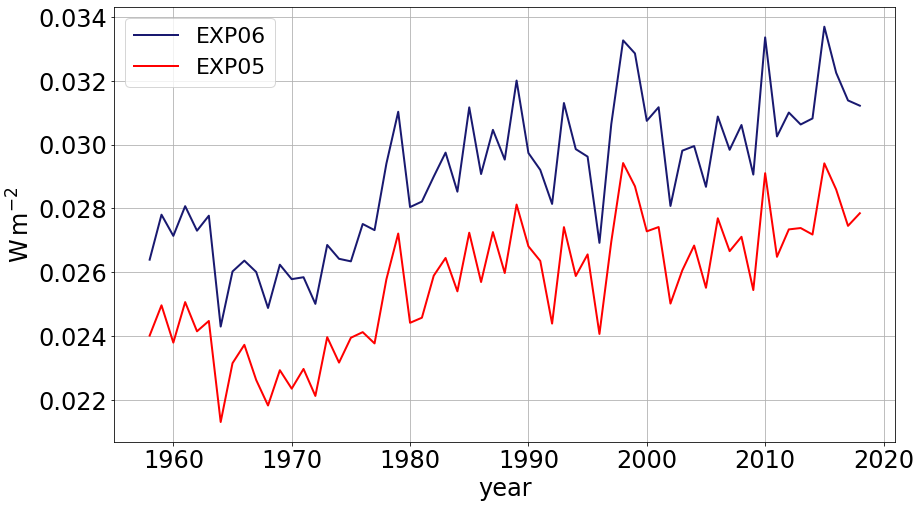

In [45]:
fig, axs = plt.subplots(figsize=(14,8))

work_6_acc_mean.plot(ax=axs, label='EXP06', color='midnightblue', linewidth=2)
work_5_acc_mean.plot(ax=axs, label= 'EXP05', color='red', linewidth=2)

# tau_6_whole_mean.plot(ax=axs, label='EXP06', color='midnightblue', linewidth=2)
# tau_5_whole_mean.plot(ax=axs, label= 'EXP05', color='red', linewidth=2)

# axs.axvline(x=dt.datetime(1978,7,1), color='k', linestyle='--', linewidth=2)
# axs.axvline(x=dt.datetime(1998,7,1), color='k', linestyle='--', linewidth=2)
axs.set_title(None)
axs.tick_params(axis= 'x', labelsize= 24)
axs.tick_params(axis= 'y', labelsize= 24)
axs.set_xlabel(None)
axs.set_ylabel('W$\,$m$^{-2}$', fontsize=24)
# axs.set_ylabel('N$\,$m$^{-2}$', fontsize=24)

axs.set_xlabel('year', fontsize=24)

axs.grid()

plt.legend(fontsize=22)
# plt.title(', loc='left', fontsize=22)

save_path = '/home/shkifmmp/_WORK/notebooks/shared-notebooks/fig_paper/diagnostics/'
# plt.savefig(save_path + 'wind_work_acc_timeseries.png', format='png', facecolor="w",  bbox_inches='tight')

### map

In [97]:
work_5_b = xr.open_mfdataset(paths=sorted(glob(datapath + 'EXP05/wind/O*_5d*_grid_wind_work.nc')),
                          chunks=({'y':100, 'x':100})).wind_work.where(mask_10_base).squeeze()

In [98]:
work_6_b = xr.open_mfdataset(paths=sorted(glob(datapath + 'EXP06/wind/O*_5d*_grid_wind_work.nc')),
                          chunks=({'y':100, 'x':100})).wind_work.where(mask_10_base).squeeze()

In [101]:
work_6_b = work_6_b.assign_coords(nav_lat = latlon_aux_base.nav_lat, nav_lon = latlon_aux_base.nav_lon)
work_5_b = work_5_b.assign_coords(nav_lat = latlon_aux_base.nav_lat, nav_lon = latlon_aux_base.nav_lon)

In [105]:
work_6 = work_6.assign_coords(nav_lat = latlon_aux.nav_lat.isel(x=slice(1,-1), y=slice(1,-1)), nav_lon = latlon_aux.nav_lon.isel(x=slice(1,-1), y=slice(1,-1)))
work_5 = work_5.assign_coords(nav_lat = latlon_aux.nav_lat.isel(x=slice(1,-1), y=slice(1,-1)), nav_lon = latlon_aux.nav_lon.isel(x=slice(1,-1), y=slice(1,-1)))

In [106]:
work_6

<xarray.DataArray 'wind_work' (time_counter: 4453, y: 627, x: 3562)>
dask.array<where, shape=(4453, 627, 3562), dtype=float32, chunksize=(73, 99, 99), chunktype=numpy.ndarray>
Coordinates:
    time_centered  (time_counter) datetime64[ns] dask.array<chunksize=(73,), meta=np.ndarray>
  * time_counter   (time_counter) datetime64[ns] 1958-01-03T12:00:00 ... 2018...
    depthu         float32 3.047
    depthv         float32 3.047
  * x              (x) int64 0 1 2 3 4 5 6 ... 3556 3557 3558 3559 3560 3561
  * y              (y) int64 0 1 2 3 4 5 6 7 ... 619 620 621 622 623 624 625 626
    nav_lon        (y, x) float32 dask.array<chunksize=(99, 99), meta=np.ndarray>
    nav_lat        (y, x) float32 dask.array<chunksize=(99, 99), meta=np.ndarray>

In [99]:
work_6.coords["x"], work_6.coords["y"] = range(len(work_6.x)), range(len(work_6.y))
work_5.coords["x"], work_5.coords["y"] = range(len(work_5.x)), range(len(work_5.y))

work_6_b.coords["x"], work_6_b.coords["y"] = range(len(work_6_b.x)), range(len(work_6_b.y))
work_5_b.coords["x"], work_5_b.coords["y"] = range(len(work_5_b.x)), range(len(work_5_b.y))

In [107]:
after_discont = ~(work_6.coords["nav_lon"].diff("x", label="upper") > 0).cumprod("x").astype(bool)
after_discont_base = ~(work_6_b.coords["nav_lon"].diff("x", label="upper") > 0).cumprod("x").astype(bool)

In [108]:
work_6.coords["nav_lon"] = (
    work_6.coords["nav_lon"]
    + 360 * after_discont)

work_6_b.coords["nav_lon"] = (
    work_6_b.coords["nav_lon"]
    + 360 * after_discont_base)

work_5.coords["nav_lon"] = (
    work_5.coords["nav_lon"]
    + 360 * after_discont)

work_5_b.coords["nav_lon"] = (
    work_5_b.coords["nav_lon"]
    + 360 * after_discont_base)

In [120]:
work_6 = work_6.isel(x=slice(1,None))
work_5 = work_5.isel(x=slice(1,None))
work_6_b = work_6_b.isel(x=slice(1,None))
work_5_b = work_5_b.isel(x=slice(1,None))

In [126]:
work_6_mean = work_6.sel(time_counter=slice('1993','2018')).mean('time_counter').compute()

work_6_b_mean = work_6_b.sel(time_counter=slice('1993','2018')).mean('time_counter').compute()

work_5_mean = work_5.sel(time_counter=slice('1993','2018')).mean('time_counter').compute()

work_5_b_mean = work_5_b.sel(time_counter=slice('1993','2018')).mean('time_counter').compute()

In [137]:
(work_6_mean - work_5_mean).min(), (work_6_b_mean - work_5_b_mean).min()

(<xarray.DataArray 'wind_work' ()>
 array(-0.02107793)
 Coordinates:
     depthu   float32 3.047
     depthv   float32 3.047,
 <xarray.DataArray 'wind_work' ()>
 array(-0.01971788)
 Coordinates:
     depthu   float32 3.047
     depthv   float32 3.047)

/home/shkifmmp/miniconda3/envs/py3_eddy/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/home/shkifmmp/miniconda3/envs/py3_eddy/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)
/home/shkifmmp/miniconda3/envs/py3_eddy/lib/pyth

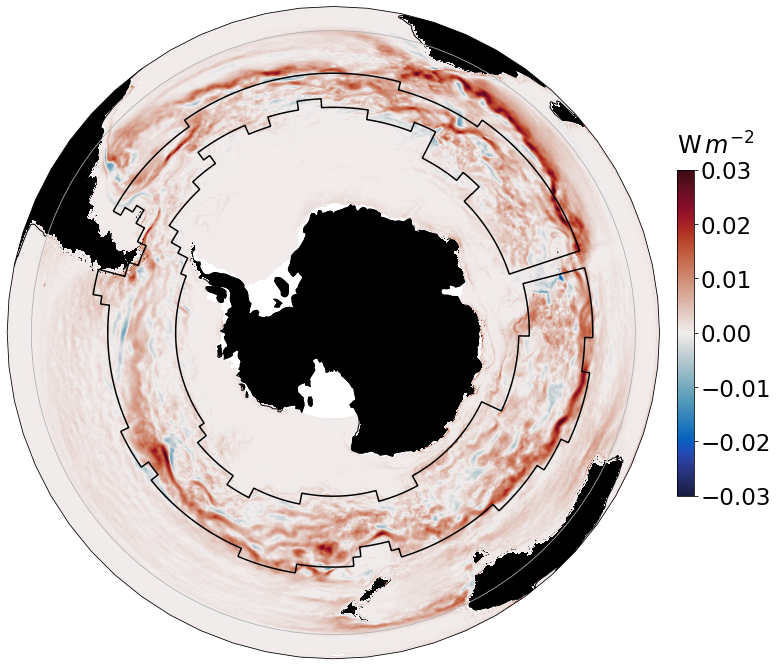

In [140]:
# plotting

fig, axs = plt.subplots(figsize=(16,12), subplot_kw = {'projection': ccrs.NearsidePerspective(central_latitude = -90)})

map1 = (work_6_mean - work_5_mean).plot(x='nav_lon', y='nav_lat', transform = ccrs.PlateCarree(), ax= axs, zorder = 3,
                               add_colorbar= False, #norm=colors.LogNorm(vmin=1e-0, vmax=1000), 
                       vmax=0.03, vmin=-0.03,
                       cmap= cm.balance)

(work_6_b_mean - work_5_b_mean).plot(x='nav_lon', y='nav_lat', transform = ccrs.PlateCarree(), ax= axs, zorder = 1,
                               add_colorbar= False,# norm=colors.LogNorm(vmin=1e-0, vmax=1000),
                  vmax=0.03, vmin=-0.03,
                               cmap = cm.balance)

axs.contour(mask_acc.nav_lon, mask_acc.nav_lat, mask_plot, transform= ccrs.PlateCarree(),
            colors='black', levels=[1], linewidth=15, zorder=5)

axs.gridlines(ylocs=[-30], zorder=7, colors='white').xlines = False

c = plt.colorbar(map1, pad=0.02, shrink=0.5, ax=axs)
c.ax.set_title('W$\,m^{-2}$', loc='left', fontsize=24, y=1.03)

axs.set_global()
axs.coastlines()
axs.add_feature(cfeature.LAND, color='black')
c.ax.tick_params(labelsize=23)
# axes.Axes.tick_params(axs, axis='both' ,labelsize=24)

axs.set_title(None)

savepath = '/home/shkifmmp/_WORK/notebooks/shared-notebooks/fig_paper/diagnostics/'
plt.savefig(savepath + 'work_9318_map_diff.png', format='png', facecolor="w", bbox_inches='tight')